In [1]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
PLOT_PARAMS()
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
import thejoker as tj
import pymc as pm
import corner
import arviz as az
plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

08_15_25


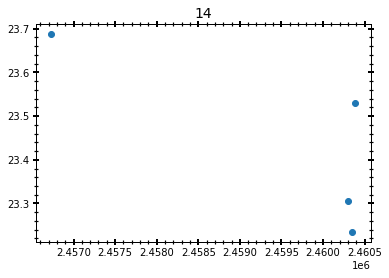

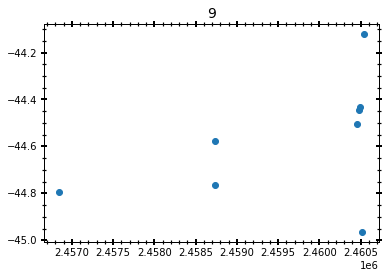

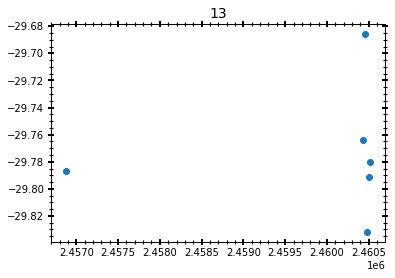

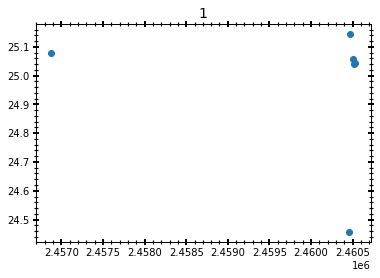

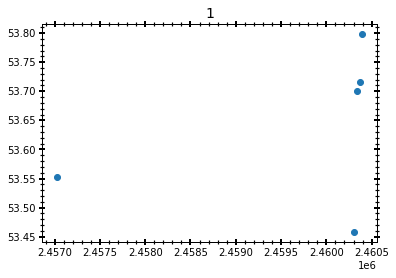

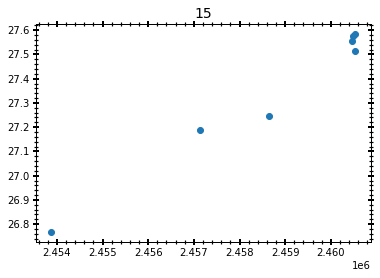

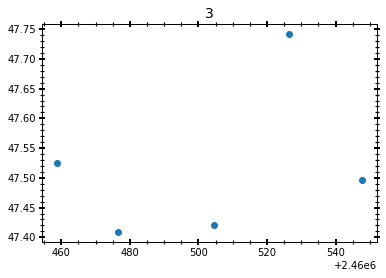

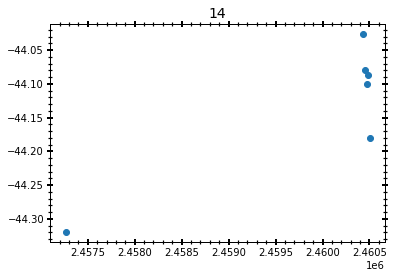

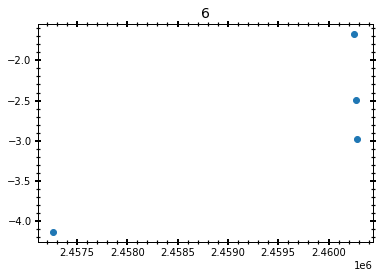

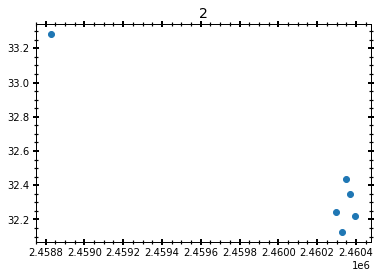

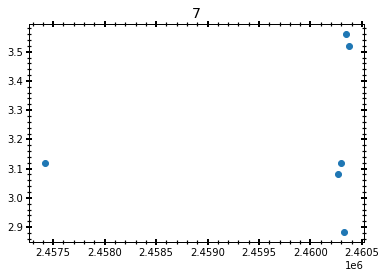

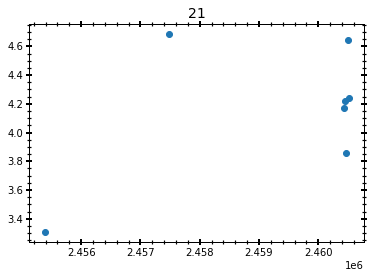

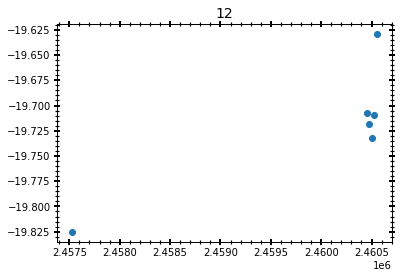

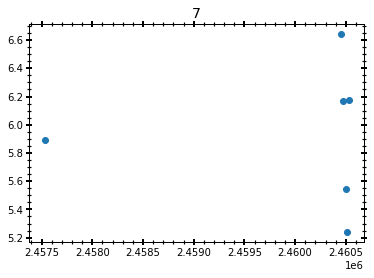

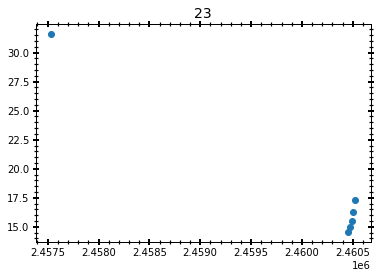

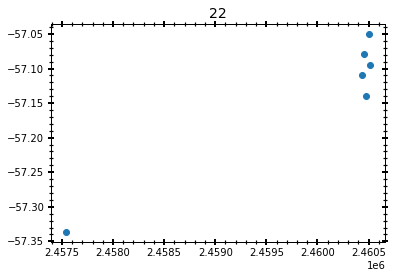

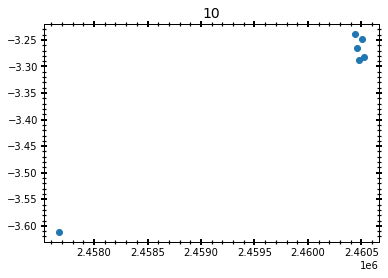

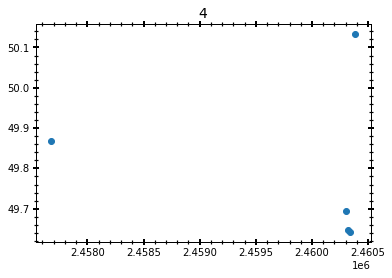

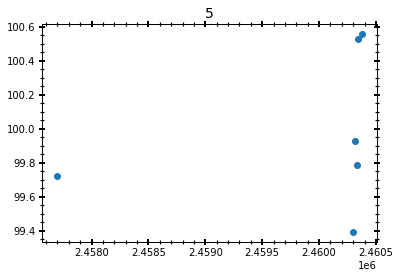

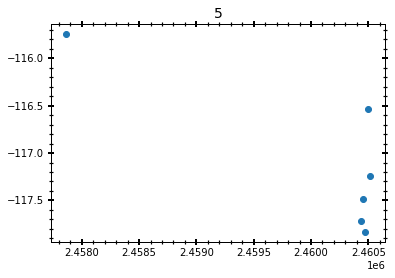

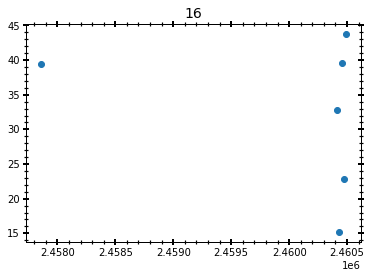

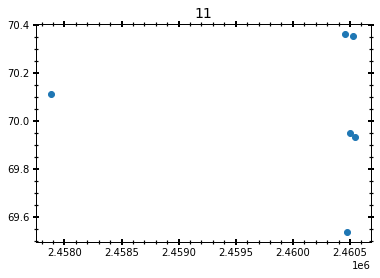

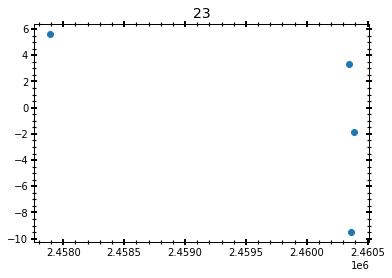

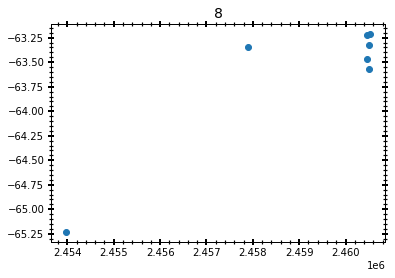

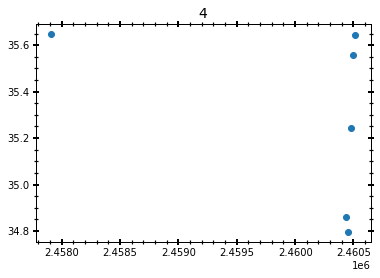

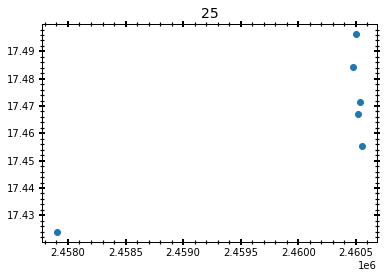

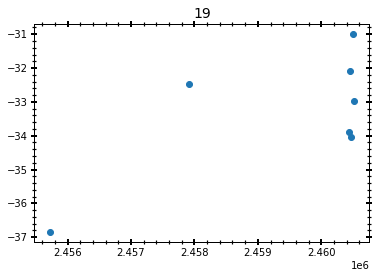

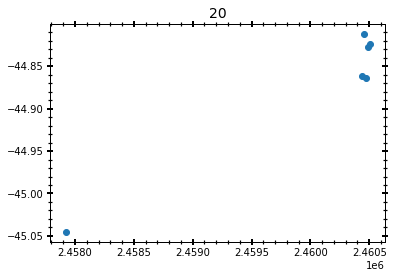

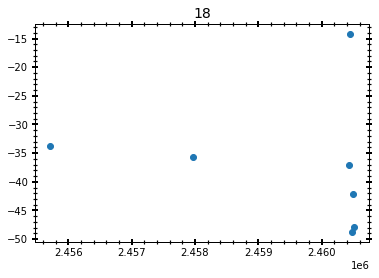

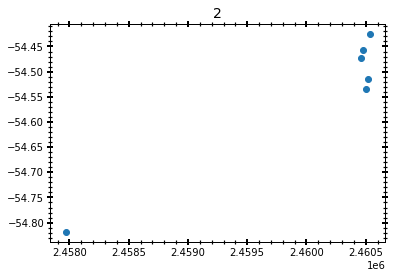

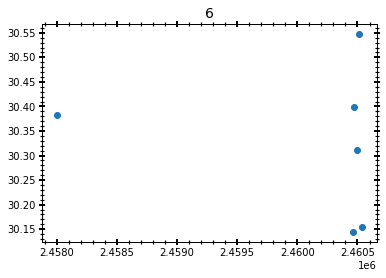

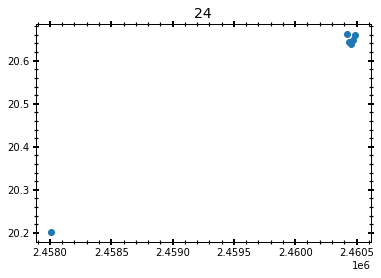

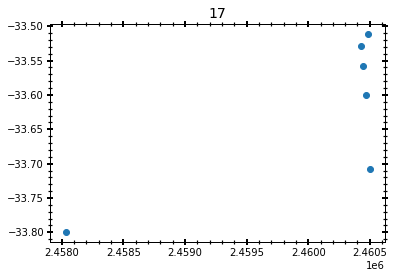

In [2]:
rv_df = pd.read_csv('rv_df.csv')
comb_df = pd.read_csv('combined_rvs.csv')


ids = comb_df.GALAH_ID.unique()
for i in ids:
    dt = comb_df[comb_df.GALAH_ID==i]
    plt.scatter(dt.time, dt.rv)
    
    plt.title(rv_df[rv_df.galah_id==i].RG_id.values[0])
    plt.show()

    


In [3]:
def clean_up(df):
    time = df['comb_time']
    rv = df['comb_rv']
    err = df['comb_rv_err']
    
    time = time.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    time = [str(t) for t in time if len(t) > 0]
    time = [float(t.split('\n')[0].replace("'","")) for t in time]
    
    rv = rv.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    rv = [t for t in rv if len(t) > 0]
    rv = [float(t.split('\n')[0]) for t in rv]
    
    err = err.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    err = [t for t in err if len(t) > 0]
    err = [float(t.split('\n')[0]) for t in err]
    
    return time, rv, err


In [4]:
obj_to_run = {}
plt.rcParams['figure.facecolor']    = 'white'

In [5]:
# dtemp = rv_df[(rv_df.RG_id==11) & (rv_df.program==112)]
# time, rv, err  = clean_up(dtemp)
# plt.scatter(time, rv)

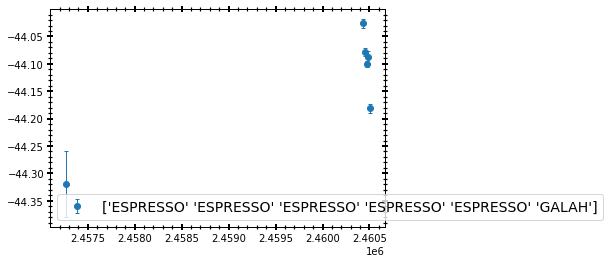

,GALAH_ID,time,rv,rv_err,source
42,150829002601352,2.460436e+06,-44.026043,0.007930,ESPRESSO
43,150829002601352,2.460474e+06,-44.100407,0.004956,ESPRESSO
44,150829002601352,2.460489e+06,-44.087469,0.010512,ESPRESSO
45,150829002601352,2.460505e+06,-44.180753,0.008092,ESPRESSO
46,150829002601352,2.460454e+06,-44.078770,0.007731,ESPRESSO
47,150829002601352,2.457264e+06,-44.319000,0.060000,GALAH


In [6]:
def plot_rvs(obj, program):
    galah_id = rv_df[(rv_df.RG_id==obj) & (rv_df.program==program)].galah_id.values[0]
    dtemp         = comb_df[comb_df.GALAH_ID==galah_id]
    time, rv, err = dtemp.time.values, dtemp.rv.values, dtemp.rv_err.values
    sources = np.array(dtemp.source.values)
    time, rv, err = np.array(time), np.array(rv), np.array(err)
    plt.errorbar(time, rv, fmt='o', yerr=err, label=sources,capsize=2,lw=1)
    plt.legend()
    plt.show()
    return dtemp
plot_rvs(14, 113)

In [7]:
import thejoker.units as xu


In [8]:
def test_tj(obj,program,Pi,Pf,force_joker=False,K0=20, max_posterior=256, error=0.1,chains=2, prior_size=50_000,save=False,MCMC=False):
    plt.rcParams['figure.facecolor']    = 'white'
    galah_id = rv_df[(rv_df.RG_id==obj) & (rv_df.program==program)].galah_id.values[0]
    dtemp         = comb_df[comb_df.GALAH_ID==galah_id]
    dtemp.dropna(inplace=True)
    time, rv, err = dtemp.time.values, dtemp.rv.values, dtemp.rv_err.values
    sources = np.array(dtemp.source.values)
    time, rv, err = np.array(time), np.array(rv), np.array(err)

    '''if program == 113 and obj in [5, 16, 11, 21, 18]: #exclude galah data point
        mask = (time >= 2460000.)
        time, rv, err = time[mask], rv[mask], err[mask]
    elif program == 112 and obj in [7, 23]:  #exclude galah data point
        mask = (time >= 2460000.)
        time, rv, err = time[mask], rv[mask], err[mask]
    '''
    err            = np.array(err)
    print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    err[(err<0.10)] = 0.10
    
    data           = Table()
    data['bjd']    = time
    data['rv']     = rv
    data['rv_err'] = err

    print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        #P_prior = xu.with_unit(pm.Uniform("P", 0.25, 1e3), u.day)
        #M0_prior    = xu.with_unit(pm.Uniform("M0", -np.pi, np.pi), u.radian)
        #omega_prior = xu.with_unit(pm.Uniform("omega", -np.pi, np.pi), u.radian)
        
        #s_prior = xu.with_unit(pm.Normal("s", 0, 0.5), u.km/u.s)
        #K_prior = xu.with_unit(pm.Normal("K", 0, 20), u.km/u.s)
        #e_prior = xu.with_unit(pm.Uniform("e", 0, 1), u.one)
        # Allow extra error to account for under-estimated error bars
        s = xu.with_unit(pm.Lognormal("s", 0, 0.5), u.km / u.s)

        prior = tj.JokerPrior.default(
                P_min = Pi * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = Pf * u.day,
                sigma_K0 = K0 * u.km / u.s,
                sigma_v = 100 * u.km / u.s,
                s=s,
            
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    
    joker = tj.TheJoker(prior, rng=rnd)

    if force_joker is True:
        print('running joker for posterior samples...')
        joker_samples = joker.rejection_sample(data, prior_samples, 
                                               max_posterior_samples=max_posterior,
                                               return_all_logprobs=True)
        print('# of joker samples returned second round:',len(joker_samples[0]))

#         fig, ax = plt.subplots(1, 1, figsize=(8, 4))

#         _ = tj.plot_rv_curves(
#                 joker_samples[0],
#                 data=data,
#                 ax=ax,
#             )
#         if save: fig.savefig('../joker_samples/%s_RG%s_%s.png'%(program,obj,DATE),bbox_inches='tight',dpi=100)

        return prior_samples, joker_samples, -999, -999, prior.par_names#az.summary(trace, var_names=prior.par_names)
        
    elif force_joker is False:
        joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=256,
                                           return_all_logprobs=True)
        print('# of joker samples returned first round:',len(joker_samples[0]))
        
        if len(joker_samples[0]) == 1:

            fig, ax = plt.subplots(1, 1, figsize=(8, 4))
            _ = tj.plot_rv_curves(
                    joker_samples[0],
                    data=data,
                    ax=ax,
                )
            if save: fig.savefig('../joker_samples/%s_RG%s_%s.png'%(program,obj,DATE),bbox_inches='tight',dpi=100)

            print('setting up mcmc...')
            with prior.model:
                mcmc_init = joker.setup_mcmc(data, joker_samples[0])
                trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=chains)

            az.summary(trace, var_names=prior.par_names)
            print('run MCMC...')
            mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
            mcmc_samples.wrap_K()
            df = mcmc_samples.tbl.to_pandas()
            colnames = []
            # ==== 3 body ====
            #truth = ['P','e','omega','M0','K','v0', 'v1', 'v2','s']
            #truth = ['P','e','K','v0', 'v1', 'v2','s']
            # ==== 2 body ====
            #truth = ['P','e','omega','M0','K','v0','s']
            truth = ['P','e','K','v0','s']

            for name in df.columns:
                if name in truth:
                    colnames.append(name)
                    #truths.append(truth[name].value)
            fig = corner.corner(df[colnames], 
                                labels=colnames,
                                quantiles=[0.16, 0.5, 0.84],
                                show_titles=True,
                                title_kwargs={"fontsize": 12}) #, truths=truths)
            if save: fig.savefig('../joker_samples/%s_RG%s_%s_corner.png'%(program, obj, DATE),bbox_inches='tight',dpi=200)
            return prior_samples, joker_samples, mcmc_samples, trace, prior.par_names#az.summary(trace, var_names=prior.par_names)
        else:
            joker_samples = joker.rejection_sample(data, prior_samples, 
                                               max_posterior_samples=max_posterior,
                                               return_all_logprobs=True)
            print('# of joker samples returned second round:',len(joker_samples[0]))

#             fig, ax = plt.subplots(1, 1, figsize=(8, 4))

#             _ = tj.plot_rv_curves(
#                     joker_samples[0],
#                     data=data,
#                     ax=ax,
#                 )
#             if save: fig.savefig('../joker_samples/%s_RG%s_%s.png'%(program,obj,DATE),bbox_inches='tight',dpi=100)

            return prior_samples, joker_samples, -999, -999, prior.par_names#az.summary(trace, var_names=prior.par_names)
    
        '''
        print('now here 1')
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        _ = tj.plot_rv_curves(
            joker_samples[0],
            data=data,
            relative_to_t_ref=True,
            ax=ax,
        )
        print('now here 2')
        if save: fig.savefig('../rv_fit/fit_%s_RG%s_%s.png'%(program,obj,DATE),bbox_inches='tight',dpi=100)
        '''
        

In [19]:
obj_to_run  = {}
program     = 112
version     = 12
force_joker = False

for k in [6]:
    obj_to_run[k] = [test_tj(k, program, force_joker=force_joker, 
                             max_posterior=10_000, Pi=1, Pf=100, chains=2, 
                             prior_size=1_000_000, save=True, MCMC=True)]

    # save mcmc
    save_dir = '../joker_samples/%s_%s_mcmc_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save trace
    save_dir = '../joker_samples/%s_%s_trace_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save joker samples
    save_dir = '../joker_samples/%s_%s_joker_%s.hdf5'%(program,k,version)
    obj_to_run[k][0][1][0].write(save_dir, overwrite=True)


error range: 0.01-0.07
error range: 0.10-0.10
# of joker samples returned first round: 175
# of joker samples returned second round: 175


In [10]:
ss

NameError: name 'ss' is not defined

In [ ]:
ss

In [ ]:
# obj_to_run[23][0][1][0]

data_113_15 = test_tj(15, 113, max_posterior=1000, Pi=1, Pf=3000, chains=2, prior_size=100_000, save=True, MCMC=True)


In [ ]:
# len(data_113_15[1])
obj_to_run[18][0][1][0]

In [ ]:
def testing():
    program = 113
    obj = 18
    version = 23
    fname = '../mcmc/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    print(joker_samples)
    
    data = Table()
    time = [2460515.54535378, 2460435.70137357, 2460499.70136402, 2460455.60377538, 2460473.83795684]
    rv = [-47.9155845974968, -37.1433239029056, -42.1163695481713, -14.1998182326159, -48.7100139602608]
    err = [0.0904713985502368, 0.022373158067569, 0.0217348085684464, 0.0280105705032669, 0.0602129211806922]

    data['bjd']     = time
    data['rv']      = rv
    data['err']     = err
    data["rv"].unit = u.km / u.s
    data["err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["err"]))
    
    print('error range: %.2f-%.2f' % (min(err),max(err)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(joker_samples, data=data, ax=ax)
    
testing()

In [ ]:
data_113_15

In [ ]:
ss

In [ ]:
data_113_19 = test_tj(19, 113, max_posterior=100, Pi=1, Pf=3000, chains=2, prior_size=100_000, save=True, MCMC=True)



In [ ]:
data_113_19

In [ ]:
plt.figure(figsize=(5,4))
plt.scatter(data_113_19[1][0]['P'].value,data_113_19[1][0]['e'].value,s=10)
plt.xscale("log")
plt.xlim(1., 3e3)
plt.xlabel('Period [days]')
plt.ylabel('Eccentricity')


# change s 

In [ ]:
data_113_23 = test_tj(23, 113, max_posterior=100_000, Pi=1, Pf=3000, chains=2, prior_size=1_000_000, save=True, MCMC=True)


In [ ]:
print(len(data_113_23[1][0]))
data = pd.DataFrame({'P': data_113_23[1][0]['P'].value, 
                     'e': data_113_23[1][0]['e'].value, 
                     'K': data_113_23[1][0]['K'].value, 
                     'v0': data_113_23[1][0]['v0'].value, 
                    })
# Plot it.
figure = corner.corner(
    data,
    labels=['P','e','K','v0'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)


In [ ]:
data_113_1 = test_tj(1, 113, max_posterior=100_000, Pi=1, Pf=3000, chains=2, prior_size=10_000_000, save=True, MCMC=True)


In [ ]:
print(len(data_113_1[1][0]))
data = pd.DataFrame({'P': data_113_1[1][0]['P'].value, 
                     'e': data_113_1[1][0]['e'].value, 
                     'K': data_113_1[1][0]['K'].value, 
                     'v0': data_113_1[1][0]['v0'].value, 
                    })
# Plot it.
figure = corner.corner(
    data,
    labels=['P','e','K','v0'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)


In [ ]:
data_112_6 = test_tj(6, 112, max_posterior=1_000_000, Pi=1, Pf=3000, chains=2, prior_size=1_000_000, save=True, MCMC=True)

In [ ]:
import corner

# data_112_6[1][0]['P'].value
data = pd.DataFrame({'P': data_112_6[1][0]['P'].value, 
                     'e': data_112_6[1][0]['e'].value, 
                     'K': data_112_6[1][0]['K'].value, 
                     'v0': data_112_6[1][0]['v0'].value, 
                    })
# Plot it.
figure = corner.corner(
    data,
    labels=['P','e','K','v0'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)


In [ ]:
plt.figure(figsize=(5,4),dpi=200)
plt.scatter(data_112_6[1][0]['P'].value,data_112_6[1][0]['e'].value,s=10)
plt.xscale("log")
plt.xlim(1., 3e3)
plt.xlabel('Period [days]')
plt.ylabel('Eccentricity')

In [ ]:
program = 112
version  = 23

# 113-1, v=18, P=2-200 :
# 113-1, v=19, P=2-1000 :
# 113-1, v=20, P=20-200 :
# 113-1, v=21, P=20-150 :
# 113-1, v=22, P=10-200 :
# 113-1, v=23, P=70-150 :

for k in [6]:
    print(k)
    obj_to_run[k] = [test_tj(k, program, Pi=1, Pf=3000, chains=2, prior_size=100_000, save=True, MCMC=True)]

    # save mcmc
    save_dir = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save trace
    save_dir = '../mcmc/%s_%s_trace_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save joker samples
    save_dir = '../mcmc/%s_%s_joker_%s.hdf5'%(program,k,version)
    obj_to_run[k][0][1][0].write(save_dir, overwrite=True)


In [ ]:
program = 113
version  = 24

# 113-1, v=18, P=2-200 :
# 113-1, v=19, P=2-1000 :
# 113-1, v=20, P=20-200 :
# 113-1, v=21, P=20-150 :
# 113-1, v=22, P=10-200 :
# 113-1, v=23, P=70-150 :

for k in [18]:
    print(k)
    obj_to_run[k] = [test_tj(k, program, Pi=10, Pf=3000, chains=2, prior_size=100_000, save=True, MCMC=True)]

    # save mcmc
    save_dir = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save trace
    save_dir = '../mcmc/%s_%s_trace_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save joker samples
    save_dir = '../mcmc/%s_%s_joker_%s.hdf5'%(program,k,version)
    obj_to_run[k][0][1][0].write(save_dir, overwrite=True)


In [ ]:
program = 113
version  = 23

# 113-1, v=18, P=2-200 : 
# 113-1, v=19, P=2-1000 : 
# 113-1, v=20, P=20-200 : 
# 113-1, v=21, P=20-150 : 
# 113-1, v=22, P=10-200 : 
# 113-1, v=23, P=70-150 : 

for k in [16]:
    print(k)
    obj_to_run[k] = [test_tj(k, program, Pi=5, Pf=7, chains=2, prior_size=100_000, save=True, MCMC=True)]

    # save mcmc
    save_dir = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save trace
    save_dir = '../mcmc/%s_%s_trace_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save joker samples
    save_dir = '../mcmc/%s_%s_joker_%s.hdf5'%(program,k,version)
    obj_to_run[k][0][1][0].write(save_dir, overwrite=True)


In [ ]:
ss